In [2]:
#!pip install opencv-contrib-python==3.4.2.16



     |████████████████████████████████| 30.6MB 1.5MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [2]:
import cv2

In [3]:
#checks if SIFT is working
sift = cv2.xfeatures2d.SIFT_create()
print(sift)

<xfeatures2d_SIFT 0x7f7c57b7e8f0>


# Program

In [4]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import json

In [5]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
import glob
import os

/usr/bin/python3
3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [10]:
#modify function to extract result size of image and get the coordinates
# Use the keypoints to stitch the images
#grab image name alsso easier for writing
def get_stitched_image(img1, img2, M, image_name, i):

    # Get width and height of input images
    w1,h1 = img1.shape[:2]
    w2,h2 = img2.shape[:2]
    
    #output_path_2 = '/home/sameer/Jupyter_Notebook/Stitching/Output/'
    #output_path_3 = '/home/sameer/Jupyter_Notebook/Stitching/Output_2/'
    
    # Get the canvas dimesions
    img1_dims = np.float32([ [0,0], [0,w1], [h1, w1], [h1,0] ]).reshape(-1,1,2)
    img2_dims_temp = np.float32([ [0,0], [0,w2], [h2, w2], [h2,0] ]).reshape(-1,1,2)


    # Get relative perspective of second image
    img2_dims = cv2.perspectiveTransform(img2_dims_temp, M)

    # Resulting dimensions
    result_dims = np.concatenate( (img1_dims, img2_dims), axis = 0)

    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
    

    # Create output array after affine transformation 
    transform_dist = [-x_min,-y_min]
    #show tha image 
    
    #plt.imshow(img2)
    transform_array = np.array([[1, 0, transform_dist[0]], 
                                [0, 1, transform_dist[1]], 
                                [0,0,1]]) 

    # Warp images to get the resulting image
    result_img = cv2.warpPerspective(img2, transform_array.dot(M), 
                                    (x_max-x_min, y_max-y_min))
    #Result_image1
    #selective image region print 
    res1 = result_img[transform_dist[1]:w1+transform_dist[1],transform_dist[0]:h1+transform_dist[0]]
    
    
    #image stitched final
    result_img[transform_dist[1]:w1+transform_dist[1], 
                transform_dist[0]:h1+transform_dist[0]] = img1
    


    #extract image2 shape since it has been pasted on the canvas
    w1,h1,_ = img2.shape
    
    #extract reusult image height and width for cropping
    w2,h2,_ = result_img.shape
    

    print('Stitching Done')

    
    return result_img


In [9]:

# Find SIFT and return Homography Matrix
def get_sift_homography(img1, img2, image_name):
     
    sift = cv2.xfeatures2d.SIFT_create()

    # Extract keypoints and descriptors
    k1, d1 = sift.detectAndCompute(img1, None)
    k2, d2 = sift.detectAndCompute(img2, None)
    if ( d1 is None or d2 is None):
      print('Images are different')
      print('Set of images from _ to ', image_name)
      
    else:

      FLANN_INDEX_KDTREE = 0
      index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
      search_params = dict(checks=50)   # or pass empty dictionary

      flann = cv2.FlannBasedMatcher(index_params,search_params)

      matches = flann.knnMatch(d1,d2,k=2)


      # Make sure that the matches are good
      verify_ratio = 0.6 # Source: stackoverflow
      verified_matches = []
      for m1,m2 in matches:
          # Add to array only if it's a good match
          if m1.distance < 1.1 * m2.distance:
              verified_matches.append(m1)

      # Mimnum number of matches
      min_matches = 9
      if len(verified_matches) > min_matches:

          # Array to store matching points
          img1_pts = []
          img2_pts = []

          # Add matching points to array
          for match in verified_matches:
              img1_pts.append(k1[match.queryIdx].pt)
              img2_pts.append(k2[match.trainIdx].pt)
          img1_pts = np.float32(img1_pts).reshape(-1,1,2)
          img2_pts = np.float32(img2_pts).reshape(-1,1,2)

          # Compute homography matrix
          M, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
          return M
      else:
        print ('Error: Not enough matches')


In [12]:

# Equalize Histogram of Color Images
def equalize_histogram_color(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img


In [20]:
#resize images before sending 
#res 640 x 480
path = '/home/sameer/Jupyter_Notebook/Demo_6_6/Images/'
cv_img = []
img_name_list = []
from skimage import exposure

#pick images from directory and add to a array. Extract filename from directory and add them to a list

#files = [item for sublist in [glob.glob(path + ext) for ext in ["/*.jpg", "/*.JPG", "/*.png", "/*.PNG"]] for item in sublist]

#print(files)
output_path = '/home/sameer/Jupyter_Notebook/Demo_6_6/Stitched/'

dict_1 = {}
 
for img in sorted(os.listdir(path)):
    if  img.endswith('jpg'):
        img= os.path.join(path,img)

        n= cv2.imread(img)
        cv_img.append(n)
        img_name_list.append(os.path.basename(img))
        #print(os.path.basename(img))

    
img1 = cv_img[0]
img1 = exposure.adjust_gamma(img1, 1.2)
previous_height = 0
for i in range(1,len(cv_img)):
    
    dict_stitch = {}
    img2 = cv_img[i]
    img2 = exposure.adjust_gamma(img2, 1.2)
    image_name = img_name_list[i]
    
    #skip histogram equal
    #img1 = equalize_histogram_color(img1)
    #img2 = equalize_histogram_color(img2)
    # Use SIFT to find keypoints and return homography matrix
    M =  get_sift_homography(img1, img2,image_name)
    
    
    
      # Stitch the images together using homography matrix
    result_image = get_stitched_image(img2, img1, M, image_name, i)
    w,h, _ = result_image.shape
    #json 
    stitch_name = 'Stitch' + str(i)
    dict_1[stitch_name]= dict_stitch
    
    dict_stitch['Image_1'] = img_name_list[i-1]
    dict_stitch['Image_2'] = img_name_list[i]
    dict_stitch['Start'] = previous_height
    dict_stitch['End'] = w


    print(dict_stitch)
    
    previous_height = w
    
    #get resulted image and save it to out file 
    
    output_file = os.path.join(output_path,str(i))
    cv2.imwrite(output_file + '.jpg', result_image)
    img1=result_image
    
    
    
    
#write dict to json file 

output_file = os.path.join(output_path, 'Stitch_Coordinates.json')
with open(output_file, 'w') as f:
            
#    json.dump(x,f)
    json.dump(dict_1,f, indent=4, sort_keys = True)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

Stitching Done
{'Start': 0, 'Image_1': 'dataset_4_ATI_20170724-172652.38.jpg', 'End': 480, 'Image_2': 'dataset_4_ATI_20170724-172657.47.jpg'}
Stitching Done
{'Start': 480, 'Image_1': 'dataset_4_ATI_20170724-172657.47.jpg', 'End': 615, 'Image_2': 'dataset_4_ATI_20170724-172658.34.jpg'}
Stitching Done
{'Start': 615, 'Image_1': 'dataset_4_ATI_20170724-172658.34.jpg', 'End': 749, 'Image_2': 'dataset_4_ATI_20170724-172659.24.jpg'}
Stitching Done
{'Start': 749, 'Image_1': 'dataset_4_ATI_20170724-172659.24.jpg', 'End': 883, 'Image_2': 'dataset_4_ATI_20170724-172700.17.jpg'}
Stitching Done
{'Start': 883, 'Image_1': 'dataset_4_ATI_20170724-172700.17.jpg', 'End': 1015, 'Image_2': 'dataset_4_ATI_20170724-172701.10.jpg'}
Stitching Done
{'Start': 1015, 'Image_1': 'dataset_4_ATI_20170724-172701.10.jpg', 'End': 1113, 'Image_2': 'dataset_4_ATI_20170724-172702.1.jpg'}
Stitching Done
{'Start': 1113, 'Image_1': 'dataset_4_ATI_20170724-172702.1.jpg', 'End': 1274, 'Image_2': 'dataset_4_ATI_20170724-172702.

In [26]:
#coordinates start from left top so mnus filan image minuthe coordinates
result_image.shape

(1038, 1205, 3)

In [27]:
img = cv2.imread('/home/sameer/Jupyter_Notebook/Stitching/data3/Output_Stitched/11.jpg')

In [28]:
img.shape

(1546, 757, 3)

In [30]:
x = 1546 - 608
print(x)

938


In [37]:
img_crop = img[938:1546, 0:757]

In [23]:
img_crop= result_image[0:1205, 0:608]

In [24]:
from matplotlib import pyplot as plt

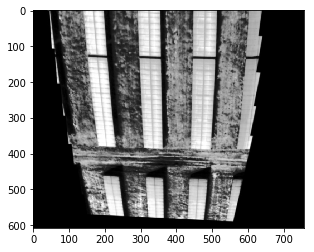

In [38]:
plt.imshow(img_crop)

# Scrtachpad

In [ ]:
#Now save all to json

In [62]:
stitch_name = 'Stitch' + str(i)

In [63]:
stitch_name

'Stitch6'

In [70]:
dict_1 = {}



In [68]:
stitch_name = 'Stitch' + str(i)
dict_1[stitch_name]= dict_stitch
dict_stitch['Image_1'] = img_name_list[i-1]
dict_stitch['Image_2'] = img_name_list[i]
dict_stitch['Start'] = previous_height
dict_stitch['End'] = w




In [69]:
dict_1

{'Stitch6': {'End': 1321,
  'Image_1': '126.jpg',
  'Image_2': '128.jpg',
  'Start': 1321}}

In [42]:
w1,h1 = img1.shape[:2]
w2,h2 = img2.shape[:2]

In [43]:
img1_dims = np.float32([ [0,0], [0,w1], [h1, w1], [h1,0] ]).reshape(-1,1,2)

In [45]:
result_dims = np.concatenate( (img1_dims, img1_dims), axis = 0)

array([[[   0.,    0.]],

       [[   0., 1038.]],

       [[1205., 1038.]],

       [[1205.,    0.]],

       [[   0.,    0.]],

       [[   0., 1038.]],

       [[1205., 1038.]],

       [[1205.,    0.]]], dtype=float32)

In [83]:
#resize images before sending 
#res 640 x 480
path = '/home/sameer/Jupyter_Notebook/Stitching/data2/input/'
cv_img = []
img_name_list = []

#pick images from directory and add to a array. Extract filename from directory and add them to a list

#files = [item for sublist in [glob.glob(path + ext) for ext in ["/*.jpg", "/*.JPG", "/*.png", "/*.PNG"]] for item in sublist]

#print(files)

dict_1 = {}
 
for img in sorted(os.listdir(path)):
    if  img.endswith('jpg'):
        img= os.path.join(path,img)

        n= cv2.imread(img)
        cv_img.append(n)
        img_name_list.append(os.path.basename(img))
        #print(os.path.basename(img))

    
img1 = cv_img[0]
previous_height = 0
for i in range(1,len(cv_img)):
    
    dict_stitch = {}
    img2 = cv_img[i]
    
    image_name = img_name_list[i]
    
    #skip histogram equal
    #img1 = equalize_histogram_color(img1)
    #img2 = equalize_histogram_color(img2)
    # Use SIFT to find keypoints and return homography matrix
    M =  get_sift_homography(img1, img2,image_name)
    
    
    
      # Stitch the images together using homography matrix
    result_image = get_stitched_image(img2, img1, M, image_name, i)
    w,h, _ = result_image.shape
    
    print('Stitched number' , i)
    print('Image_names' , img_name_list[i-1],'and', img_name_list[i])
    if(not(previous_height > w)):
        
        print('Start position', previous_height)
        print('End Position', w)
    else:
        print('Images are not stitching in order')
        print('Start position', previous_height)
        print('End Position', w)
        print('---------------------Ignore below----------------------------')
    #print('Height',w)
    #json 
    stitch_name = 'Stitch' + str(i)
    dict_1[stitch_name]= dict_stitch
    
    dict_stitch['Image_1'] = img_name_list[i-1]
    dict_stitch['Image_2'] = img_name_list[i]
    dict_stitch['Start'] = previous_height
    dict_stitch['End'] = w


    print(dict_stitch)
    
    previous_height = w
    
    #get resulted image and save it to out file 
    output_path = '/home/sameer/Jupyter_Notebook/Stitching/data2/Output_Stitched/'
    output_file = os.path.join(output_path,str(i))
    cv2.imwrite(output_file + '.jpg', result_image)
    print('\n')
    img1=result_image
    
    
    
    
#write dict to json file 

output_file = os.path.join(output_path, 'Stitch_Coordinates.json')
with open(output_file, 'w') as f:
            
#    json.dump(x,f)
    json.dump(dict_1,f, indent=4, sort_keys = True)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

Done
Stitched number 1
Image_names 121.jpg and 122.jpg
Start position 0
End Position 620
{'Image_1': '121.jpg', 'Image_2': '122.jpg', 'Start': 0, 'End': 620}


Done
Stitched number 2
Image_names 122.jpg and 123.jpg
Start position 620
End Position 763
{'Image_1': '122.jpg', 'Image_2': '123.jpg', 'Start': 620, 'End': 763}


Done
Stitched number 3
Image_names 123.jpg and 124.jpg
Start position 763
End Position 903
{'Image_1': '123.jpg', 'Image_2': '124.jpg', 'Start': 763, 'End': 903}


Done
Stitched number 4
Image_names 124.jpg and 125.jpg
Start position 903
End Position 1013
{'Image_1': '124.jpg', 'Image_2': '125.jpg', 'Start': 903, 'End': 1013}


Done
Stitched number 5
Image_names 125.jpg and 126.jpg
Start position 1013
End Position 1181
{'Image_1': '125.jpg', 'Image_2': '126.jpg', 'Start': 1013, 'End': 1181}


Done
Stitched number 6
Image_names 126.jpg and 128.jpg
Start position 1181
End Position 1321
{'Image_1': '126.jpg', 'Image_2': '128.jpg', 'Start': 1181, 'End': 1321}




In [80]:
output_file = os.path.join(output_path, 'Stitch_Coordinates.json')

In [81]:
output_file

'/home/sameer/Jupyter_Notebook/Stitching/data2/Output_Stitched/Stitch_Coordinates.json'

In [31]:
'''i=imutils.resize(cv_img[0], width=1920)
img1= i
for i in range(1,10):

    
    img2 = imutils.resize(cv_img[i], width=1920)


    img1 = equalize_histogram_color(img1)
    img2 = equalize_histogram_color(img2)

    # Show input images
    #input_images = np.hstack( (img1, img2) )
    #cv2.imshow ('Input Images', input_images)

    # Use SIFT to find keypoints and return homography matrix
    M =  get_sift_homography(img1, img2)

    # Stitch the images together using homography matrix
    result_image = get_stitched_image(img2, img1, M)

    # Write the result to the same directory
    #	result_image_name = 'results/result_'+sys.argv[1]
    cv2.imwrite(str(i) + 'output.jpg',result_image)
    resultimage = imutils.resize(resultimage, width=1920)
    img1=result_image
''' 

"i=imutils.resize(cv_img[0], width=1920)\nimg1= i\nfor i in range(1,10):\n\n    \n    img2 = imutils.resize(cv_img[i], width=1920)\n\n\n    img1 = equalize_histogram_color(img1)\n    img2 = equalize_histogram_color(img2)\n\n    # Show input images\n    #input_images = np.hstack( (img1, img2) )\n    #cv2.imshow ('Input Images', input_images)\n\n    # Use SIFT to find keypoints and return homography matrix\n    M =  get_sift_homography(img1, img2)\n\n    # Stitch the images together using homography matrix\n    result_image = get_stitched_image(img2, img1, M)\n\n    # Write the result to the same directory\n    #\tresult_image_name = 'results/result_'+sys.argv[1]\n    cv2.imwrite(str(i) + 'output.jpg',result_image)\n    resultimage = imutils.resize(resultimage, width=1920)\n    img1=result_image\n"

In [45]:
#resize images before sending 
#res 640 x 480
path = '/home/sameer/Jupyter_Notebook/Stitching/input/'
cv_img = []
img_name_list = []

#pick images from directory and add to a array. Extract filename from directory and add them to a list

#files = [item for sublist in [glob.glob(path + ext) for ext in ["/*.jpg", "/*.JPG", "/*.png", "/*.PNG"]] for item in sublist]

#print(files)


 
for img in sorted(os.listdir(path)):
    if  img.endswith('jpg'):
        img= os.path.join(path,img)

        n= cv2.imread(img)
        cv_img.append(n)
        img_name_list.append(os.path.basename(img))
        #print(os.path.basename(img))

    
img1 = cv_img[0]
previous_height = 0
for i in range(1,len(cv_img)):
    
    
    img2 = cv_img[i]
    
    
    # Use SIFT to find keypoints and return homography matrix
    M =  get_sift_homography(img1, img2,image_name)
    image_name = img_name_list[i]
    
    
      # Stitch the images together using homography matrix
    result_image = get_stitched_image(img2, img1, M, image_name, i)
    w,h, _ = result_image.shape
    
    print('Stitched number' , i)
    print('Image_names' , img_name_list[i-1],'and', img_name_list[i])
    print('Start position', previous_height)
    print('End Position', w)
    #print('Height',w)
    
    previous_height = w
    
    #get resulted image and save it to out file 
    output_path = '/home/sameer/Jupyter_Notebook/Stitching/Output_Stitched/'
    output_file = os.path.join(output_path,str(i))
    cv2.imwrite(output_file + '.jpg', result_image)
    print('\n')
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

Done
Stitched number 1
Image_names dataset_4_ATI_20170724-172508.68.jpg and dataset_4_ATI_20170724-172509.60.jpg
Start position 0
End Position 618


Done
Stitched number 2
Image_names dataset_4_ATI_20170724-172509.60.jpg and dataset_4_ATI_20170724-172511.36.jpg
Start position 618
End Position 892




In [12]:
list1 = []
list1 = [0,0,157,271,402,538,674,813,943,1073,1208,1336,1474]




In [17]:
for i in range (0,len(list1)):
    print(list1[i])

0
0
157
271
402
538
674
813
943
1073
1208
1336
1474
